In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2022-01-24 17:34:17.932938: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-24 17:34:18.740599: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /device:GPU:0 with 30519 MB memory:  -> device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2043486295358457378,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 32002277376
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5028322695146414898
 physical_device_desc: "device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0"]

In [3]:
import os
print(os.listdir('./data/flowers'))

['dandelion', 'daisy', 'sunflower', 'tulip', 'rose']


In [4]:
batch_size = 32
img_height = 160
img_width = 160
img_size = (img_height, img_width)

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  './data/flowers',
  validation_split = 0.2,
  subset = "training",
  seed=123,
  image_size=img_size,
  batch_size=batch_size)

Found 4317 files belonging to 5 classes.
Using 3454 files for training.


2022-01-24 17:34:19.135516: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30519 MB memory:  -> device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  './data/flowers',
  validation_split = 0.2,
  subset = "validation",
  seed=123,
  image_size=img_size,
  batch_size=batch_size)

Found 4317 files belonging to 5 classes.
Using 863 files for validation.


2022-01-24 17:34:19.936494: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


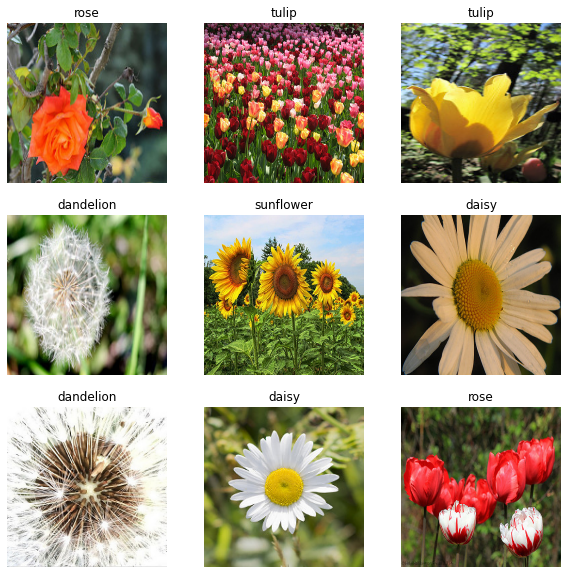

In [7]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [8]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

In [9]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 22
Number of test batches: 5


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_dataset = val_ds.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_ds.prefetch(buffer_size=AUTOTUNE)

In [11]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

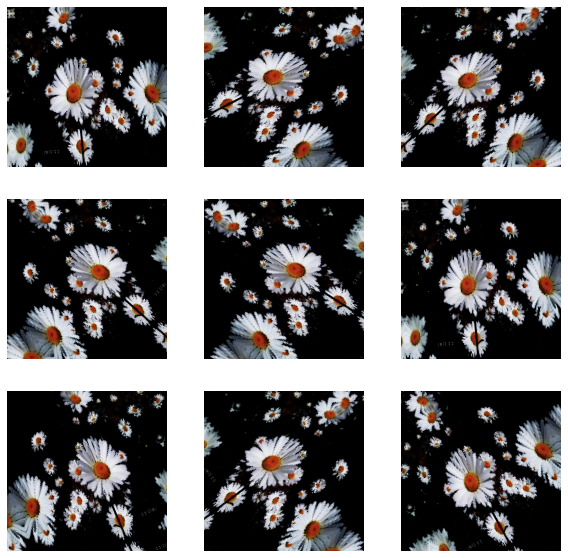

In [12]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [13]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [14]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [15]:
IMG_SHAPE = img_size + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [16]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

2022-01-24 17:34:24.853790: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201


(32, 5, 5, 1280)


In [17]:
base_model.trainable = False

In [18]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [19]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [20]:
prediction_layer = tf.keras.layers.Dense(5)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 5)


In [21]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [22]:
from tensorflow.python.keras.utils import losses_utils
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, 
                                                                  reduction=losses_utils.ReductionV2.AUTO,
                                                                  name='sparse_categorical_crossentropy'),
                                                                  metrics=['sparse_categorical_accuracy'])

/home/c4nd0it/anaconda3/envs/keras_env/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [23]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [24]:
len(model.trainable_variables)

2

In [25]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

22/22 [==============================] - 2s 23ms/step - loss: 8.6797 - sparse_categorical_accuracy: 0.1935


In [26]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 8.68
initial accuracy: 0.19


In [27]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
108/108 [==============================] - 4s 22ms/step - loss: 8.0719 - sparse_categorical_accuracy: 0.2516 - val_loss: 7.7448 - val_sparse_categorical_accuracy: 0.2802
Epoch 2/10
108/108 [==============================] - 2s 19ms/step - loss: 6.4147 - sparse_categorical_accuracy: 0.3274 - val_loss: 4.9947 - val_sparse_categorical_accuracy: 0.3385
Epoch 3/10
108/108 [==============================] - 2s 19ms/step - loss: 3.5859 - sparse_categorical_accuracy: 0.3755 - val_loss: 2.1519 - val_sparse_categorical_accuracy: 0.3784
Epoch 4/10
108/108 [==============================] - 2s 19ms/step - loss: 2.1432 - sparse_categorical_accuracy: 0.3752 - val_loss: 1.7060 - val_sparse_categorical_accuracy: 0.3698
Epoch 5/10
108/108 [==============================] - 2s 19ms/step - loss: 1.7399 - sparse_categorical_accuracy: 0.3770 - val_loss: 1.6127 - val_sparse_categorical_accuracy: 0.3713
Epoch 6/10
108/108 [==============================] - 2s 19ms/step - loss: 1.6675 - sparse_cate

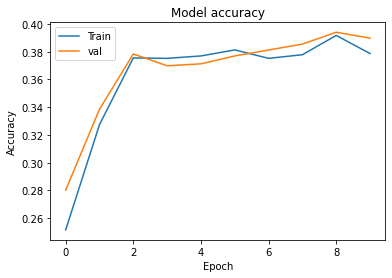

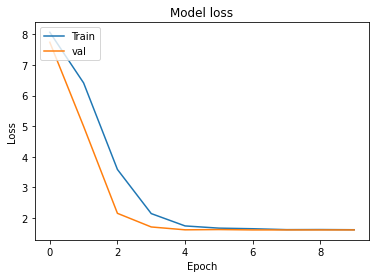

In [28]:
epoch_range = range(0, initial_epochs)
plt.plot(epoch_range, history.history['sparse_categorical_accuracy'])
plt.plot(epoch_range, history.history['val_sparse_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'val'], loc='upper left')
plt.show()

plt.plot(epoch_range, history.history['loss'])
plt.plot(epoch_range, history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'val'], loc='upper left')
plt.show()

In [29]:
base_model.trainable = True

In [30]:
print("Number of layers in the base model: ", len(base_model.layers))
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [31]:
from tensorflow.python.keras.utils import losses_utils
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, 
                                                                  reduction=losses_utils.ReductionV2.AUTO,
                                                                  name='sparse_categorical_crossentropy'),
                                                                  metrics=['sparse_categorical_accuracy'])

In [32]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [33]:
len(model.trainable_variables)

56

In [34]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs
history_fine = model.fit(
                    train_dataset,
                    validation_data=validation_dataset,
                    epochs = total_epochs,
                    initial_epoch=history.epoch[-1])

Epoch 10/20
108/108 [==============================] - 7s 32ms/step - loss: 1.6239 - sparse_categorical_accuracy: 0.2093 - val_loss: 1.6094 - val_sparse_categorical_accuracy: 0.1935
Epoch 11/20
108/108 [==============================] - 3s 26ms/step - loss: 1.6094 - sparse_categorical_accuracy: 0.1928 - val_loss: 1.6094 - val_sparse_categorical_accuracy: 0.2063
Epoch 12/20
108/108 [==============================] - 3s 25ms/step - loss: 1.6094 - sparse_categorical_accuracy: 0.1928 - val_loss: 1.6094 - val_sparse_categorical_accuracy: 0.2006
Epoch 13/20
108/108 [==============================] - 3s 26ms/step - loss: 1.6094 - sparse_categorical_accuracy: 0.1948 - val_loss: 1.6094 - val_sparse_categorical_accuracy: 0.1963
Epoch 14/20
108/108 [==============================] - 3s 26ms/step - loss: 1.6135 - sparse_categorical_accuracy: 0.2030 - val_loss: 1.6094 - val_sparse_categorical_accuracy: 0.2390
Epoch 15/20
108/108 [==============================] - 3s 26ms/step - loss: 1.6094 - spars

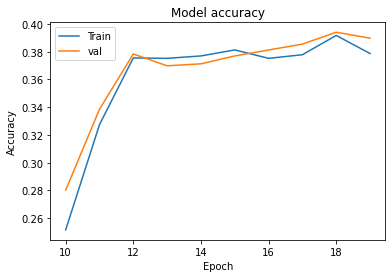

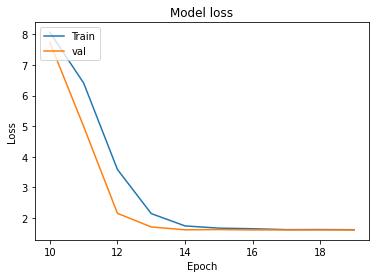

In [35]:
epoch_range = range(10, total_epochs)
plt.plot(epoch_range, history.history['sparse_categorical_accuracy'])
plt.plot(epoch_range, history.history['val_sparse_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'val'], loc='upper left')
plt.show()

plt.plot(epoch_range, history.history['loss'])
plt.plot(epoch_range, history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'val'], loc='upper left')
plt.show()